## Imports

In [1]:
import bilby
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import seaborn as sns
import corner
import glob

from astropy import cosmology, units
from astropy.cosmology import Planck15
from scipy.interpolate import interp1d

from bilby.core.prior import Uniform, LogUniform, PriorDict, Constraint
import gwpopulation as gwpop
from gwpopulation.models import mass, spin, redshift
from gwpopulation.conversions import convert_to_beta_parameters

from matplotlib import rcParams
rcParams["text.usetex"] = True
rcParams["font.serif"] = "Computer Modern"
rcParams["font.family"] = "Serif"
rcParams["xtick.labelsize"]=14
rcParams["ytick.labelsize"]=14
rcParams["xtick.direction"]="in"
rcParams["ytick.direction"]="in"
rcParams["legend.fontsize"]=15
rcParams["axes.labelsize"]=16
rcParams["axes.grid"] = True
rcParams["grid.color"] = 'black'
rcParams["grid.linewidth"] = 1.
rcParams["grid.alpha"] = 0.6

from bilby.core.utils import logger
from gwpopulation import vt
from gwpopulation.cupy_utils import xp
from bilby.hyper.model import Model

### Posteriors

In [2]:
luminosity_distances = np.linspace(1, 10000, 1000)
redshifts = np.array([cosmology.z_at_value(cosmology.Planck15.luminosity_distance, 
                                                   dl * units.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)

#### GWTC-1

In [3]:
parameter_translator = dict(
    mass_1_det = 'm1_detector_frame_Msun',
    mass_2_det = 'm2_detector_frame_Msun',
    luminosity_distance = 'luminosity_distance_Mpc',
    a_1 = 'spin1',
    a_2 = 'spin2',
    cos_tilt_1 = 'costilt1',
    cos_tilt_2 = 'costilt2')

posteriors = list()
event = list()
i = 0

file = '../../GWTC-1/GWTC-1_sample_release/{}_GWTC-1.hdf5'

events1 = ['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 
          'GW170729', 'GW170809', 'GW170814', 'GW170818', 'GW170823']

for e in events1:
    print(i, e)
    i = i+1
    event.append(e)
    _posterior = pd.DataFrame()
    with h5py.File(file.format(e), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff['prior'][gwtc_key]
    posteriors.append(_posterior)
    
for posterior in posteriors:
    posterior['redshift'] = dl_to_z(posterior['luminosity_distance'])
    posterior['mass_1'] = posterior['mass_1_det'] / (1 + posterior['redshift'])
    posterior['mass_2'] = posterior['mass_2_det'] / (1 + posterior['redshift'])
    posterior['mass_ratio'] = posterior['mass_2'] / posterior['mass_1']
    del posterior["mass_1_det"]
    del posterior["mass_2_det"]

0 GW150914
1 GW151012
2 GW151226
3 GW170104
4 GW170608
5 GW170729
6 GW170809
7 GW170814
8 GW170818
9 GW170823


#### GWTC-2

In [14]:
!wget https://dcc.ligo.org/public/0169/P2000223/007/GW190728_064510.tar

--2021-05-03 17:47:50--  https://dcc.ligo.org/public/0169/P2000223/007/GW190728_064510.tar
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448501760 (428M) [application/x-tar]
Saving to: ‘GW190728_064510.tar’

100%[======================================>] 448,501,760 70.3MB/s   in 6.0s   

2021-05-03 17:47:56 (70.7 MB/s) - ‘GW190728_064510.tar’ saved [448501760/448501760]



In [15]:
!tar -xvf GW190728_064510.tar

GW190728_064510/
GW190728_064510/GW190728_064510.h5
GW190728_064510/GW190728_064510_comoving.h5
GW190728_064510/GW190728_064510_prior_comoving.npy
GW190728_064510/GW190728_064510_C01:SEOBNRv4P.fits
GW190728_064510/GW190728_064510_PrecessingSpinIMR.fits
GW190728_064510/GW190728_064510_PublicationSamples.fits
GW190728_064510/GW190728_064510_ZeroSpinIMR.fits
GW190728_064510/GW190728_064510_C01:IMRPhenomD.fits
GW190728_064510/GW190728_064510_C01:IMRPhenomPv2.fits
GW190728_064510/GW190728_064510_C01:SEOBNRv4PHM.fits
GW190728_064510/GW190728_064510_PrecessingSpinIMRHM.fits


In [19]:
file = 'GW190728_064510/GW190728_064510.h5'
f = h5py.File(file, 'r')
f.keys()
# f['PrecessingSpinIMR'].keys()

<KeysViewHDF5 ['C01:IMRPhenomD', 'C01:IMRPhenomPv2', 'C01:SEOBNRv4P', 'C01:SEOBNRv4PHM', 'PrecessingSpinIMR', 'PrecessingSpinIMRHM', 'PublicationSamples', 'ZeroSpinIMR', 'history', 'version']>

In [13]:
file = '../../GWTC-2/GWTC-2_sample_release/S190408an.h5'
f = h5py.File(file, 'r')
f.keys()
# f['PrecessingSpinIMR'].keys()

<KeysViewHDF5 ['C01:IMRPhenomD', 'C01:IMRPhenomPv2', 'C01:SEOBNRv4P', 'C01:SEOBNRv4PHM', 'PrecessingSpinIMR', 'PrecessingSpinIMRHM', 'ZeroSpinIMR', 'history', 'version']>

In [4]:
parameter_translator = dict(
    mass_1 = 'mass_1_source',
    mass_2 = 'mass_2_source',
    mass_ratio = 'mass_ratio',
    luminosity_distance = 'luminosity_distance',
    a_1 = 'a_1',
    a_2 = 'a_2',
    cos_tilt_1 = 'cos_tilt_1',
    cos_tilt_2 = 'cos_tilt_2',
    redshift = 'redshift')

# 44 events excluding
# S190425z.h5
# S190426c.h5
# S190719an.h5
# S190814bv.h5
# S190909w.h5

events2 = ['S190408an.h5', 'S190412m.h5', 'S190413ac.h5', 
          'S190413i.h5', 'S190421ar.h5', 'S190424ao.h5', 
          'S190503bf.h5', 'S190512at.h5', 'S190513bm.h5',
          'S190514n.h5', 'S190517h.h5', 'S190519bj.h5',
          'S190521g.h5', 'S190521r.h5', 'S190527w.h5',
          'S190602aq.h5', 'S190620e.h5', 'S190630ag.h5',
          'S190701ah.h5', 'S190706ai.h5', 'S190707q.h5',
          'S190708ap.h5', 'S190720a.h5', 'S190727h.h5',
          'S190728q.h5', 'S190731aa.h5', 'S190803e.h5',
          'S190828j.h5', 'S190828l.h5', 'S190910s.h5', 
          'S190915ak.h5', 'S190924h.h5', 'S190929d.h5',
          'S190930s.h5']

file = '../../GWTC-2/GWTC-2_sample_release/{}'

for e in events2:
    print(i, e)
    i = i+1
    _posterior = pd.DataFrame()
    with h5py.File(file.format(e), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff["PrecessingSpinIMRHM"]['prior'][gwtc_key]
    posteriors.append(_posterior)
    e = e[:-3]
    event.append(e)

10 S190408an.h5


KeyError: "Unable to open object (object 'prior' doesn't exist)"

In [5]:
print(event, len(event))

['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729', 'GW170809', 'GW170814', 'GW170818', 'GW170823', 'S190408an', 'S190412m', 'S190413ac', 'S190413i', 'S190421ar', 'S190424ao', 'S190503bf', 'S190512at', 'S190513bm', 'S190514n', 'S190517h', 'S190519bj', 'S190521g', 'S190521r', 'S190527w', 'S190602aq', 'S190620e', 'S190630ag', 'S190701ah', 'S190706ai', 'S190707q', 'S190708ap', 'S190720a', 'S190727h', 'S190728q', 'S190731aa', 'S190803e', 'S190828j', 'S190828l', 'S190910s', 'S190915ak', 'S190924h', 'S190929d', 'S190930s'] 44


In [6]:
BOUNDS = dict(
    mass_1=(2, 100),
    mass_ratio=(0, 1),
    a_1=(0, 1),
    a_2=(0, 1),
    cos_tilt_1=(-1, 1),
    cos_tilt_2=(-1, 1),
    redshift=(0, 2.3))

PRIOR_VOLUME = (
    (BOUNDS["mass_1"][1] - BOUNDS["mass_1"][0]) ** 2
    * (BOUNDS["a_1"][1] - BOUNDS["a_1"][0])
    * (BOUNDS["a_2"][1] - BOUNDS["a_2"][0])
    * (BOUNDS["cos_tilt_1"][1] - BOUNDS["cos_tilt_1"][0]))

for posterior in posteriors:
    posterior["prior"] = 1./PRIOR_VOLUME

### Calculation

In [7]:
modelA = bilby.hyper.model.Model([mass.SinglePeakSmoothedMassDistribution(),
                                  spin.iid_spin_magnitude_beta,
                                  spin.iid_spin_orientation_gaussian_isotropic])

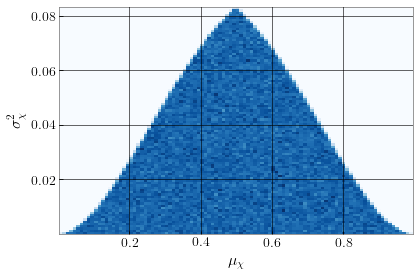

In [12]:
# Test

def mu_var_max_to_alpha_beta_max(parameters):
    mu = parameters["mu_chi"]
    var = parameters["sigma_chi"]
#     alpha = (mu ** 2 * (1 - mu) - mu * var) / var
#     beta = (mu * (1 - mu) ** 2 - (1 - mu) * var) / var
    parameters["alpha_chi"] = (mu ** 2 * (1 - mu) - mu * var) / var
    parameters["beta_chi"] = (mu * (1 - mu) ** 2 - (1 - mu) * var) / var
    return parameters


priors = PriorDict(conversion_function = mu_var_max_to_alpha_beta_max)

# spin magnitude 
priors["mu_chi"] = Uniform(minimum = 0, maximum = 1, latex_label = r'$\mu_\chi$')
priors["sigma_chi"] = Uniform(minimum = 0, maximum = 0.25, latex_label = r'$\sigma^2_\chi$')
priors["alpha_chi"] = Constraint(minimum = 1, maximum = 1e5)
priors["beta_chi"] = Constraint(minimum = 1, maximum = 1e5)


samples = priors.sample(1000000)
plt.hist2d(samples['mu_chi'], samples['sigma_chi'], bins=100, cmap='Blues')
plt.xlabel(r'$\mu_{\chi}$')
plt.ylabel(r'$\sigma^2_{\chi}$')
plt.tight_layout()
plt.show()
plt.close()

### Selection Effects

In [8]:
# Check the structure of VT file

vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'

ff = h5py.File(vt_file, 'r')
print(list(ff.keys()))
print(list(ff['injections'].keys()))
print(list(ff.attrs.items()))

['injections']
['distance', 'gps_time_int', 'ifar_gstlal', 'ifar_pycbc_bbh', 'ifar_pycbc_full', 'mass1_source', 'mass2_source', 'optimal_snr_h', 'optimal_snr_l', 'redshift', 'sampling_pdf', 'spin1z', 'spin2z']
[('N_exp/R(z=0)', 979.0426119706958), ('analysis_time_s', 15843600), ('max_redshift', 2.3), ('n_accepted', 156878), ('n_rejected', 76825621), ('surveyed_VT_Gpc_yr', 167.60465680916), ('total_generated', 76982499)]


In [9]:
# VT Function

def _load_pycbc_injection_data(vt_file, ifar_threshold, vt_name="N_exp/R(z=0)"):
    logger.info(f"Loading VT data from {vt_file}.")
    f = h5py.File(vt_file, 'r')
    
    Tobs = f.attrs['analysis_time_s']/(365.25*24*3600) # years
    Ndraw = f.attrs['total_generated']
    m1 = np.array(f['injections/mass1_source'])
    m2 = np.array(f['injections/mass2_source'])
    z = np.array(f['injections/redshift'])
    s1z = np.array(f['injections/spin1z'])
    s2z = np.array(f['injections/spin2z'])
    p_draw = np.array(f['injections/sampling_pdf'])
    gstlal_ifar = np.array(f['injections/ifar_gstlal'])
    pycbc_ifar = np.array(f['injections/ifar_pycbc_full'])
    pycbc_bbh_ifar = np.array(f['injections/ifar_pycbc_bbh'])
    
    found = ((pycbc_bbh_ifar > ifar_threshold) | (pycbc_ifar > ifar_threshold) | (gstlal_ifar > ifar_threshold))
    gwpop_data = dict(
        mass_1 = xp.asarray(m1[found]),
        mass_ratio = xp.asarray(m2[found] / m1[found]),
        redshift = xp.asarray(z[found]),
        prior = xp.asarray(p_draw[found]),
        n_found = xp.sum(found),
        total_generated = Ndraw,
        analysis_time = Tobs)
    return gwpop_data

def injection_resampling_vt(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["mass_1"] ** (-2.35 + 1) * data["mass_ratio"] ** 2

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def load_vt():
    vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'
    vt_model = Model([mass.SinglePeakSmoothedMassDistribution()])
    vt_func = injection_resampling_vt
    
    return vt_func(vt_file, model = vt_model)

selection_function = load_vt()

15:48 bilby INFO    : Loading VT data from ../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf.


In [10]:
def prior_conversion1(parameters):
    mu = parameters["mu_chi"]
    var = parameters["sigma_chi"]
    parameters["alpha_chi"] = (mu ** 2 * (1 - mu) - mu * var) / var
    parameters["beta_chi"] = (mu * (1 - mu) ** 2 - (1 - mu) * var) / var
    return parameters

def prior_conversion2(parameters):
    mu = parameters["mu_chi"]
    var = parameters["sigma_chi"]
    added_keys = pd.DataFrame()
    parameters["alpha_chi"] = (mu ** 2 * (1 - mu) - mu * var) / var
    parameters["beta_chi"] = (mu * (1 - mu) ** 2 - (1 - mu) * var) / var
    added_keys["alpha_chi"] = parameters["alpha_chi"]
    added_keys["beta_chi"] = parameters["beta_chi"]
    return parameters, added_keys

In [11]:
priorsA = PriorDict(conversion_function = prior_conversion1)

# rate 
priorsA["rate"] = LogUniform(minimum=1e-1, maximum=1e3, latex_label=r'$R$', boundary="reflective")

# mass
priorsA["alpha"] = Uniform(minimum=-4., maximum=12., latex_label=r'$\alpha$', boundary='reflective')
priorsA["beta"] = Uniform(minimum=-4., maximum=12., latex_label=r'$\beta_q$')
priorsA['delta_m'] = Uniform(minimum=0., maximum=10., latex_label=r'$\delta_m$ $[M_\odot]$')
priorsA["mmin"] = Uniform(minimum=2., maximum=10., latex_label=r'$m_\mathrm{min}$ $[M_\odot]$')
priorsA['mmax'] = Uniform(minimum=30., maximum=100., latex_label=r'$m_\mathrm{max}$ $[M_\odot]$')
priorsA['lam'] = Uniform(minimum=0., maximum=1., latex_label=r'$\lambda_\mathrm{peak}$')
priorsA['mpp'] = Uniform(minimum=20., maximum=50., latex_label=r'$\mu_m$ $[M_\odot]$')
priorsA['sigpp'] = Uniform(minimum=0.4, maximum=10., latex_label=r'$\sigma_m$ $[M_\odot]$')

# spin magnitude 
priorsA["mu_chi"] = Uniform(minimum = 0, maximum = 1, latex_label = r'$\mu_\chi$')
priorsA["sigma_chi"] = Uniform(minimum = 0, maximum = 0.25, latex_label = r'$\sigma^2_\chi$')
priorsA["amax"] = 1
priorsA["alpha_chi"] = Constraint(minimum = 1, maximum = 1e5)
priorsA["beta_chi"] = Constraint(minimum = 1, maximum = 1e5)

# spin orientation
priorsA["xi_spin"] = Uniform(minimum = 0, maximum = 1, latex_label=r'$\zeta$')
priorsA["sigma_spin"] = Uniform(minimum = 0.01, maximum = 4, latex_label=r'$\sigma_t$')

# # redshift
# priorsA["lamb"] = 0

In [12]:
likelihoodA = gwpop.hyperpe.RateLikelihood(posteriors = posteriors, 
                                           hyper_prior = modelA,
                                           conversion_function = prior_conversion2,
                                           selection_function = selection_function)

In [13]:
for ii in range(10):
    likelihoodA.parameters.update(priorsA.sample())
    print(likelihoodA.parameters)
    print(likelihoodA.log_likelihood_ratio())

{'rate': 17.737698072226397, 'alpha': 1.778263692284142, 'beta': 10.744519065365017, 'delta_m': 6.4642148162414035, 'mmin': 3.9321353806289814, 'mmax': 66.63994260025439, 'lam': 0.7317321038939678, 'mpp': 44.725481273996444, 'sigpp': 9.686733380485002, 'mu_chi': 0.20050892435786327, 'sigma_chi': 0.013589417891934297, 'amax': 1.0, 'xi_spin': 0.279337225470349, 'sigma_spin': 3.3155464539574866, 'alpha_chi': 2.164758119866792, 'beta_chi': 8.631559933304679}
319.60932973371797
{'rate': 94.33364760108383, 'alpha': 0.9091730300817602, 'beta': 2.2839204568289375, 'delta_m': 2.9049375107681707, 'mmin': 2.447716486830048, 'mmax': 60.58690664389317, 'lam': 0.3689087896151647, 'mpp': 37.03116926243356, 'sigpp': 2.071868352224268, 'mu_chi': 0.4547783985923425, 'sigma_chi': 0.06556118806313127, 'amax': 1.0, 'xi_spin': 0.47020103548388015, 'sigma_spin': 2.0206370757760235, 'alpha_chi': 1.2652114952983466, 'beta_chi': 1.516828063340554}
331.8800462593091
{'rate': 109.61285054486139, 'alpha': 5.368102

In [12]:
likelihoodA.parameters.update(priorsA.sample())
likelihoodA.log_likelihood_ratio()

423.88550678139404

In [ ]:
resultA = bilby.run_sampler(likelihood = likelihoodA, priors = priorsA, sampler='dynesty', 
                            nlive = 1000, label='default_vt_fixed_redshift_alpha', 
                            outdir = 'default_vt_fixed_redshift_alpha', clean = True)

15:55 bilby INFO    : Running for label 'default_vt_fixed_redshift_alpha', output will be saved to 'default_vt_fixed_redshift_alpha'
15:55 bilby INFO    : Search parameters:
15:55 bilby INFO    :   rate = LogUniform(minimum=0.1, maximum=1000.0, name=None, latex_label='$R$', unit=None, boundary='reflective')
15:55 bilby INFO    :   alpha = Uniform(minimum=-4.0, maximum=12.0, name=None, latex_label='$\\alpha$', unit=None, boundary='reflective')
15:55 bilby INFO    :   beta = Uniform(minimum=-4.0, maximum=12.0, name=None, latex_label='$\\beta_q$', unit=None, boundary=None)
15:55 bilby INFO    :   delta_m = Uniform(minimum=0.0, maximum=10.0, name=None, latex_label='$\\delta_m$ $[M_\\odot]$', unit=None, boundary=None)
15:55 bilby INFO    :   mmin = Uniform(minimum=2.0, maximum=10.0, name=None, latex_label='$m_\\mathrm{min}$ $[M_\\odot]$', unit=None, boundary=None)
15:55 bilby INFO    :   mmax = Uniform(minimum=30.0, maximum=100.0, name=None, latex_label='$m_\\mathrm{max}$ $[M_\\odot]$', uni

0it [00:00, ?it/s]

15:55 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7ff1140ce430>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
15:55 bilby INFO    : Checkpoint every check_point_delta_t = 600s
15:55 bilby INFO    : Using dynesty version 1.0.1
15:55 bilby INFO    : Using the bilby-implemented rwalk sam

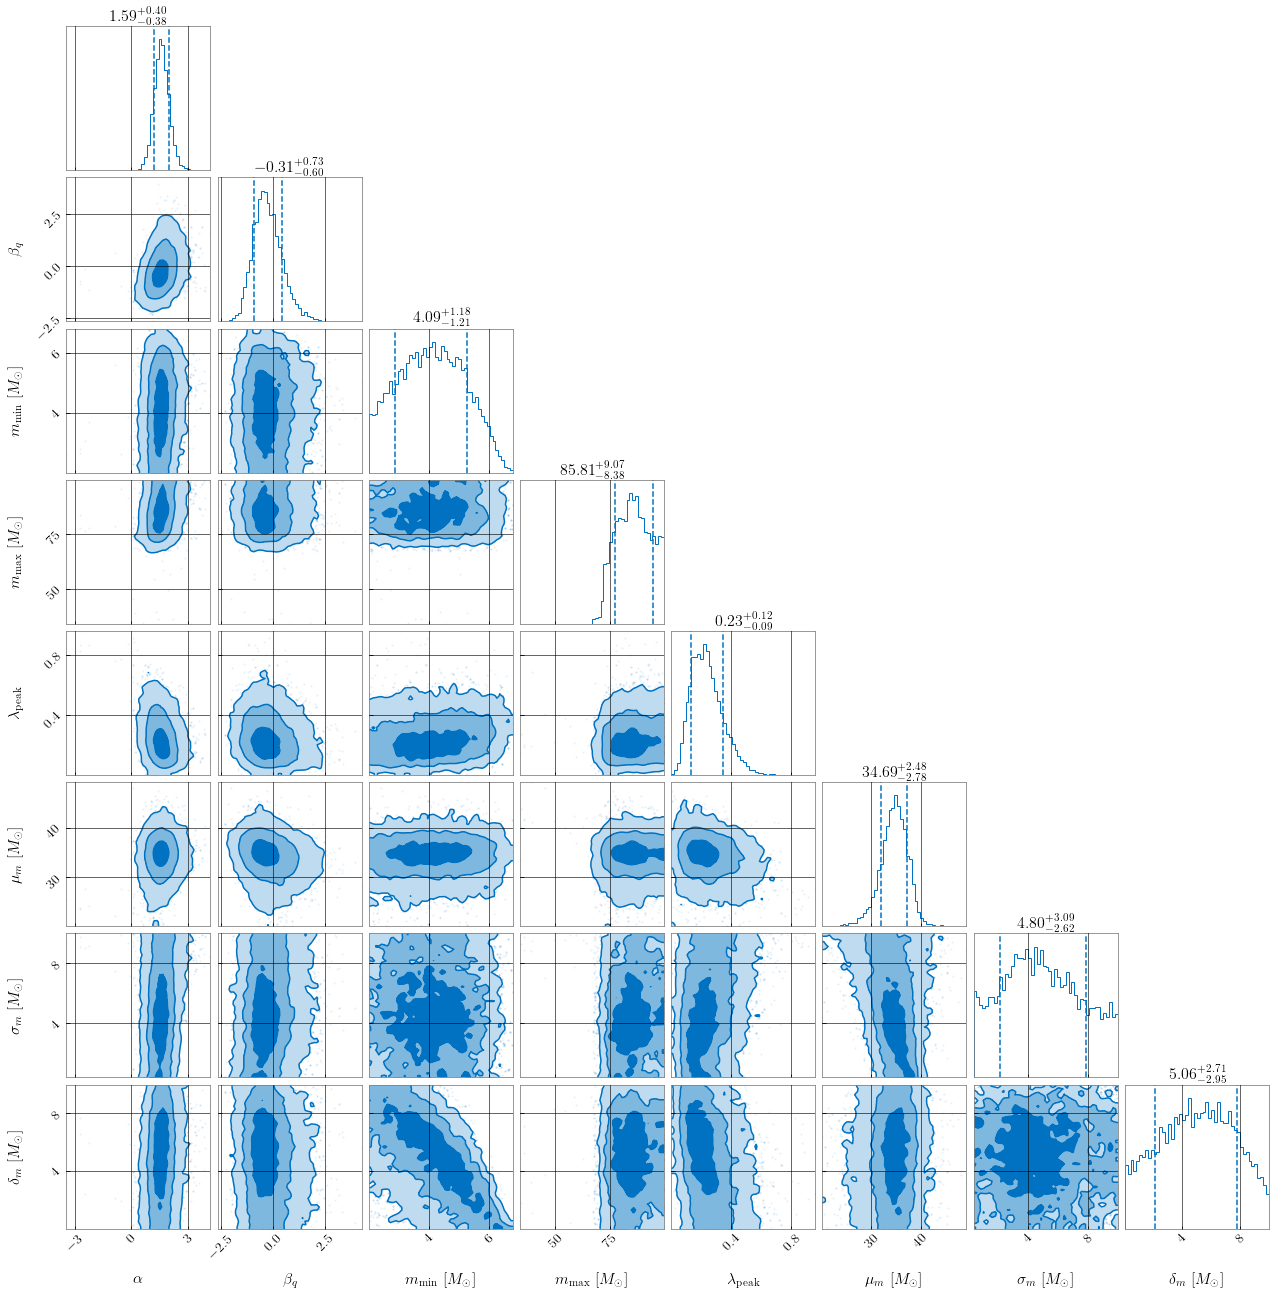

In [15]:
resultA.plot_corner(parameters = ('alpha', 'beta', 'mmin', 'mmax', 'lam', 'mpp', 'sigpp', 'delta_m'))

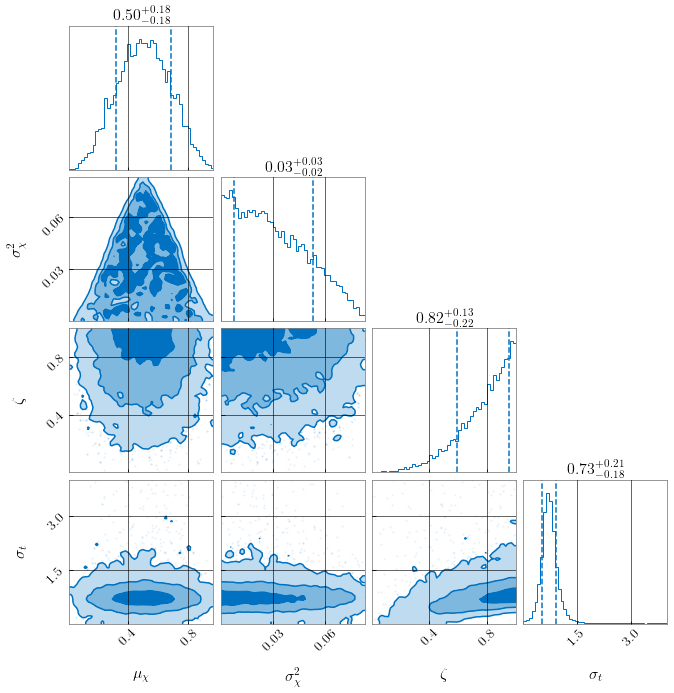

In [16]:
resultA.plot_corner(parameters = ('mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin'))